In [1]:
!wget --no-check-certificate \
    https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip \
    -O /content/cell_images.zip

--2021-11-24 13:12:37--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 13.226.115.3, 13.226.115.49, 13.226.115.117, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|13.226.115.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘/content/cell_images.zip’

/content/cell_image 100%[===================>] 337.08M   105MB/s    in 3.8s    

2021-11-24 13:12:41 (88.1 MB/s) - ‘/content/cell_images.zip’ saved [353452851/353452851]



In [2]:
import os
import zipfile

local_zip = '/content/cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cell_images')
zip_ref.close()

In [3]:
img_height=224
img_width=224
batch_size = 64

In [4]:
data_dir='/content/cell_images/cell_images'

In [5]:
import tensorflow as tf

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 19291 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 8267 files for validation.


In [8]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
img_augmentation = tf.keras.models.Sequential([
                                           tf.keras.layers.RandomRotation(factor=(-0.5,0.5)),
                                           tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.3),
                                                                             width_factor=(-0.2, 0.3)),
                                           tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3)),
                                           tf.keras.layers.RandomFlip('horizontal_and_vertical')
])

In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

In [17]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_height, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"]
    )
    return model

In [18]:
model=build_model(1)

16719872/16705208 [==============================] - 0s 0us/step


In [19]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['sequential[1][0]']             
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']   

In [20]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    restore_best_weights=True,
)

In [21]:
history = model.fit(
      train_ds,
      steps_per_epoch=8,  
      epochs=100,
      verbose=1, 
      callbacks=[callback],
      validation_data = val_ds,
      validation_steps=8)

Epoch 1/100
8/8 [==============================] - 6s 748ms/step - loss: 0.4728 - accuracy: 0.8652 - val_loss: 0.3315 - val_accuracy: 0.8457
Epoch 3/100
8/8 [==============================] - 6s 768ms/step - loss: 0.4197 - accuracy: 0.8652 - val_loss: 0.2663 - val_accuracy: 0.8887
Epoch 4/100
8/8 [==============================] - 6s 752ms/step - loss: 0.4870 - accuracy: 0.8652 - val_loss: 0.2902 - val_accuracy: 0.8750
Epoch 5/100
8/8 [==============================] - 6s 762ms/step - loss: 0.3932 - accuracy: 0.8457 - val_loss: 0.4599 - val_accuracy: 0.7383
Epoch 6/100
8/8 [==============================] - 6s 767ms/step - loss: 0.3504 - accuracy: 0.8867 - val_loss: 0.2213 - val_accuracy: 0.9590
Epoch 7/100
8/8 [==============================] - 5s 742ms/step - loss: 0.4161 - accuracy: 0.8711 - val_loss: 0.2440 - val_accuracy: 0.8965
Epoch 8/100
8/8 [==============================] - 5s 737ms/step - loss: 0.3958 - accuracy: 0.8809 - val_loss: 0.2662 - val_accuracy: 0.9102
Epoch 9/100
8

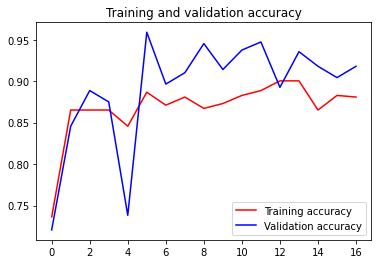

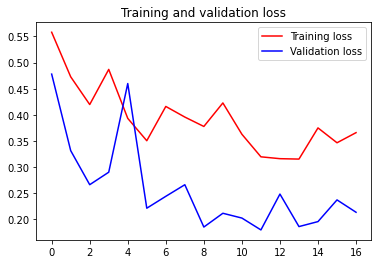

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [23]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def pred(fn):
  path =  fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  img = mpimg.imread(fn)
  imgplot = plt.imshow(img)
  plt.show()
  if classes[0]>0.5:
    print("image is a unifected")
  else:
    print("image is a parasitized")

[0.36237746]


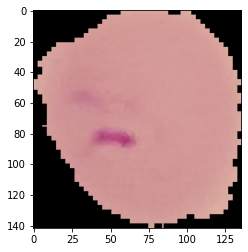

image is a parasitized


In [28]:
pred('/content/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_140.png')